#**Model calculation: Vibronic coupling between excited states of a molecular heterodimer**

> This code supplements Figure 32 of the Chemical Reviews article titled "Coherence in Chemistry: Foundations and Frontiers" ([doi.org/10.1021/acs.chemrev.3c00643](https://doi.org/10.1021/acs.chemrev.3c00643))


To begin, press the play button beside each cell (proceed sequentially through the cells).

In [ ]:
#@title Import libraries, prep plot settings

import matplotlib.pyplot as plt
import numpy as np
from math import *
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [ ]:
#@title Tunable parameters

e1 = 15000            # energy of molecule 1 excited electronic state (occupancy-number basis) [cm-1]
e2 = 16300            # energy of molecule 2 excited electronic state (occupancy-number basis) [cm-1]
J = 10                # value of electronic coupling (Coulombic, dipole-dipole) [cm-1]
wfreq = 1300          # vibrational frequency [cm-1]
displacement = 0.8    # dimensionless displacement along nuclear coordinate
vmax = 30             # maximum viberational quanta allowed in dimer Hamiltonian



> **NOTE:** *the maximum allowed vibrational quanta (vmax) can be lowered to increase the speed of the simulation (when vmax = 30, the final code cell takes ca. 30 seconds to complete), but be wary that effects from basis set truncation manifest at small vmax values*.



In [ ]:
#@title Define basis and operator functions

def ground(vmax):           # generate vibronic basis kets for the electronic ground state
    basis = []
    for v1 in range(vmax):
        for v2 in range(vmax-v1):
          temp = np.array([0,v1,0,v2])
          basis.append(temp)
    return basis

def excited(vmax):          # generate vibronic basis kets for the electronic excited state
    basis = []
    for n in range(2):
        m = not(n)
        for v1 in range(vmax):
            for v2 in range(vmax-v1):
                temp = np.array([n,v1,m,v2])
                basis.append(temp)
    return basis

def elecre(basis,states,molnum):                # electronic creation operator
    c = np.zeros([states,states],dtype=float)
    ind = 2*(molnum-1)
    for i in range(states):
        for j in range(states):
            bra = basis[i].copy()
            ket = basis[j].copy()
            if (ket[ind] == 1):
               ket[ind] = 0
               if (ket == bra).all():
                  c[i,j] = 1
    return c

def vibcre(basis,states,molnum):                # vibrational creation operator
    b = np.zeros([states,states],dtype=float)

    for i in range(states):
        for j in range(states):
            bra = basis[i].copy()
            ket = basis[j].copy()
            ket[2*molnum-1] = ket[2*molnum-1]-1
            if (ket == bra).all():
               b[i,j] = sqrt(ket[2*molnum-1]+1)
    return b

In [ ]:
#@title Define function for generating Hamiltonian

def genHam(e1,e2,J,wfreq,displacement,vmax):

  # Create basis kets (occupancy number basis)
  gbasis = ground(vmax)
  ebasis = excited(vmax)
  basis = gbasis+ebasis
  states = len(basis)
  fock = np.identity(states);

  # construct electronic creation operators for monomer 1 (m1) and monomer 2 (m2)
  cm1 = elecre(basis,states,1)
  cm2 = elecre(basis,states,2)

  # construct vibrational creation operators for m1 and m2
  bm1 = vibcre(basis,states,1)
  bm2 = vibcre(basis,states,2)

  Hem1 = e1*np.matmul(cm1.transpose(),cm1)    # generate electronic Hamiltonian for m1
  Hem2 = e2*np.matmul(cm2.transpose(),cm2)    # generate electronic Hamiltonian for m2

  lambda_sqr = np.zeros([states,states],dtype=float) # matrix of lambda squared (just for convenience)
  Hetot = np.add(Hem1,Hem2)
  for i in range(states):
    if (Hetot[i,i] == 1):
      lambda_sqr[i,i] = displacement**2

  Hem1em2 = J*(np.matmul(cm1.transpose(),cm2)+np.matmul(cm2.transpose(),cm1))                             # generate electronic Hamiltonian (Condon approximation valid)
  Hvm1 = wfreq*np.matmul(bm1.transpose(),bm1)                                                             # generate vibrational Hamiltonian for m1
  Hvm2 = wfreq*np.matmul(bm2.transpose(),bm2)                                                             # generate vibrational Hamiltonian for m2
  Hevm1 = wfreq*np.matmul(np.matmul(cm1.transpose(),cm1),displacement*(bm1.transpose()+bm1)+lambda_sqr)   # generate vibronic coupling Hamiltonian for m1
  Hevm2 = wfreq*np.matmul(np.matmul(cm2.transpose(),cm2),displacement*(bm2.transpose()+bm2)+lambda_sqr)   # generate vibronic coupling Hamiltonian for m2
  H = np.sum([Hem1, Hem2, Hem1em2, Hvm1, Hvm2, Hevm1, Hevm2], axis=0)                                     # combine all pieces to full Hamiltonian

  w, v = np.linalg.eig(H)  # w = eigenvalues, v = eigenvectors

  return w, v, states, fock, H

In [ ]:
#@title Define projection function

def  proj_gen(v_exc,fock_exc,states):

    fockm2 = fock_exc[:,0:(states//2)].copy()       # divide electronic excited-state fock matrix into m1 and m2 number-basis states
    fockm1 = fock_exc[:,(states//2):].copy()

    m2character = 0
    m1character = 0

    for i in range(states//2):                      # loop through m1 and m2 number-basis states and sum up the projections onto the eigenvectors
        m2frac = np.abs(np.matmul(v_exc.transpose(),fockm2[:,i]));
        m2character = m2character+m2frac;

        m1frac = np.abs(np.matmul(v_exc.transpose(),fockm1[:,i]));
        m1character = m1character+m1frac;

    m2percent = []
    m1percent = []
    for i in range(states):                         # normalize so that each eigenvector is 100% comprised of m1 and m2 contributions
      normval = np.add(m2character[i],m1character[i])
      perc2 = 100*m2character[i]/(normval)
      m2percent.append(perc2)
      perc1 = 100*m1character[i]/(normval)
      m1percent.append(perc1)

    return m2percent, m1percent

(13884.597481246485, 18250.0)

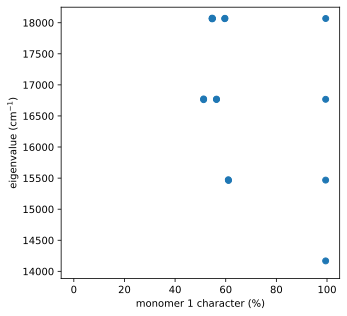

In [ ]:
#@title Decompose eigenvectors into contributions from number-basis states (& plot)

w, v, states, fock, H = genHam(e1,e2,J,wfreq,displacement,vmax)

w_exc = w[0:(2*states//3)].copy()
v_exc = v[(states//3):,0:(2*states//3)].copy()
fock_exc = fock[(states//3):,(states//3):].copy()
m2percent, m1percent = proj_gen(v_exc,fock_exc,(2*states//3))    # Decompose eigenvectors into contributions from m1 and m2

fig = plt.figure(figsize=(5, 5))
plt.scatter(m1percent,w_exc)
plt.xlabel("monomer 1 character (%)")
plt.ylabel("eigenvalue (cm$^{-1}$)")
plt.xlim([-5, 105])
plt.ylim([0.98*np.amin(w_exc), e1+2.5*wfreq])